In [5]:
import scanpy as sc 
import pandas as pd
import os
import warnings

In [6]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [30]:
results_file = "C:/Users/supak/github/resultsc/GSE184950_test.h5ad"

In [8]:
directory = 'C:/Users/supak/workplace/singlecell/GSE184950_RAW/data/'
dirs = os.listdir(directory)
print(dirs)

['GSM5602315_A10_CTL_filtered_feature_bc_matrix', 'GSM5602316_A15_PDD_filtered_feature_bc_matrix', 'GSM5602317_A18_PDD_filtered_feature_bc_matrix', 'GSM5602318_A2_CTL_filtered_feature_bc_matrix', 'GSM5602319_A29_PDD_filtered_feature_bc_matrix', 'GSM5602320_A31_PDD_filtered_feature_bc_matrix', 'GSM5602321_A38_PDD_filtered_feature_bc_matrix', 'GSM5602322_B13_PDD_filtered_feature_bc_matrix', 'GSM5602323_B19_PDD_filtered_feature_bc_matrix', 'GSM5602324_B25_PD_filtered_feature_bc_matrix', 'GSM5602325_B28_PDD_filtered_feature_bc_matrix', 'GSM5602326_B33_PDD_filtered_feature_bc_matrix', 'GSM5602327_B5_CTL_filtered_feature_bc_matrix', 'GSM5602328_B9_CTL_filtered_feature_bc_matrix', 'GSM5602329_C1_CTL_filtered_feature_bc_matrix', 'GSM5602330_C11_PD_filtered_feature_bc_matrix', 'GSM5602331_C18_PD_filtered_feature_bc_matrix', 'GSM5602332_C20_PD_filtered_feature_bc_matrix', 'GSM5602333_C26_PDD_filtered_feature_bc_matrix', 'GSM5602335_C8_CTL_filtered_feature_bc_matrix', 'GSM5602336_D16_PDD_filtered

In [9]:
dfs = []

for filename in dirs:
    name = filename.replace('_filtered_feature_bc_matrix', '').split('_')
    Patient = name[1]
    Type = name[2]
    
    matrix_file = os.path.join(directory, filename)
    
    adata = sc.read_10x_mtx(matrix_file,
                            var_names='gene_symbols')
    
    adata.obs['Patient'] = Patient
    adata.obs['Type'] = Type
    
    df = pd.DataFrame(adata.obs)
    
    dfs.append(df)
    
merge_df = pd.concat(dfs)
print(merge_df)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

In [10]:
adata

AnnData object with n_obs × n_vars = 18139 × 33538
    obs: 'Patient', 'Type'
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


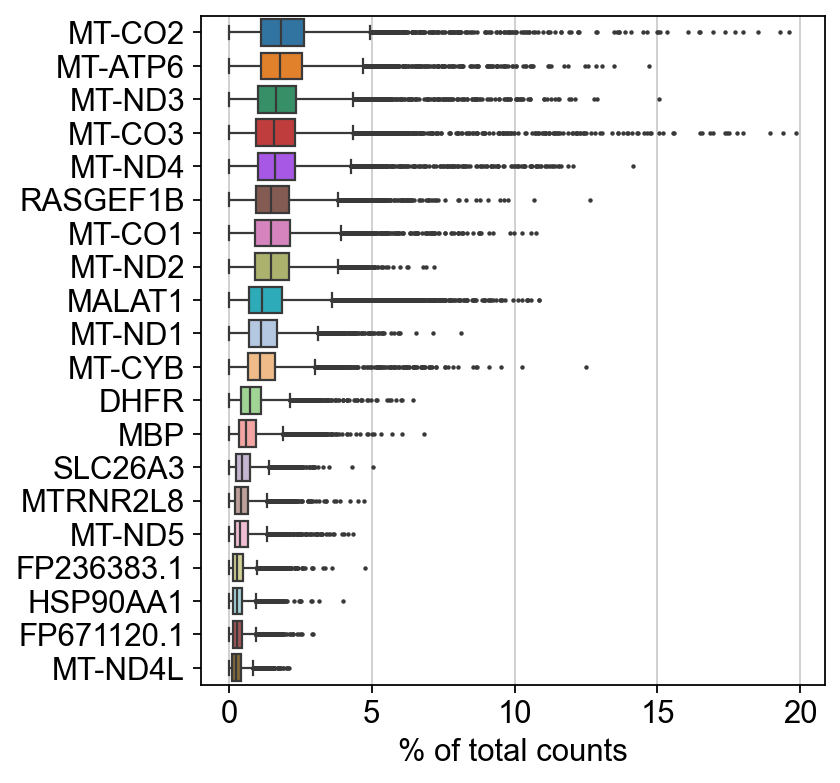

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 9600 genes that are detected in less than 3 cells


In [13]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], 
    percent_top=None, 
    log1p=False, 
    inplace=True)

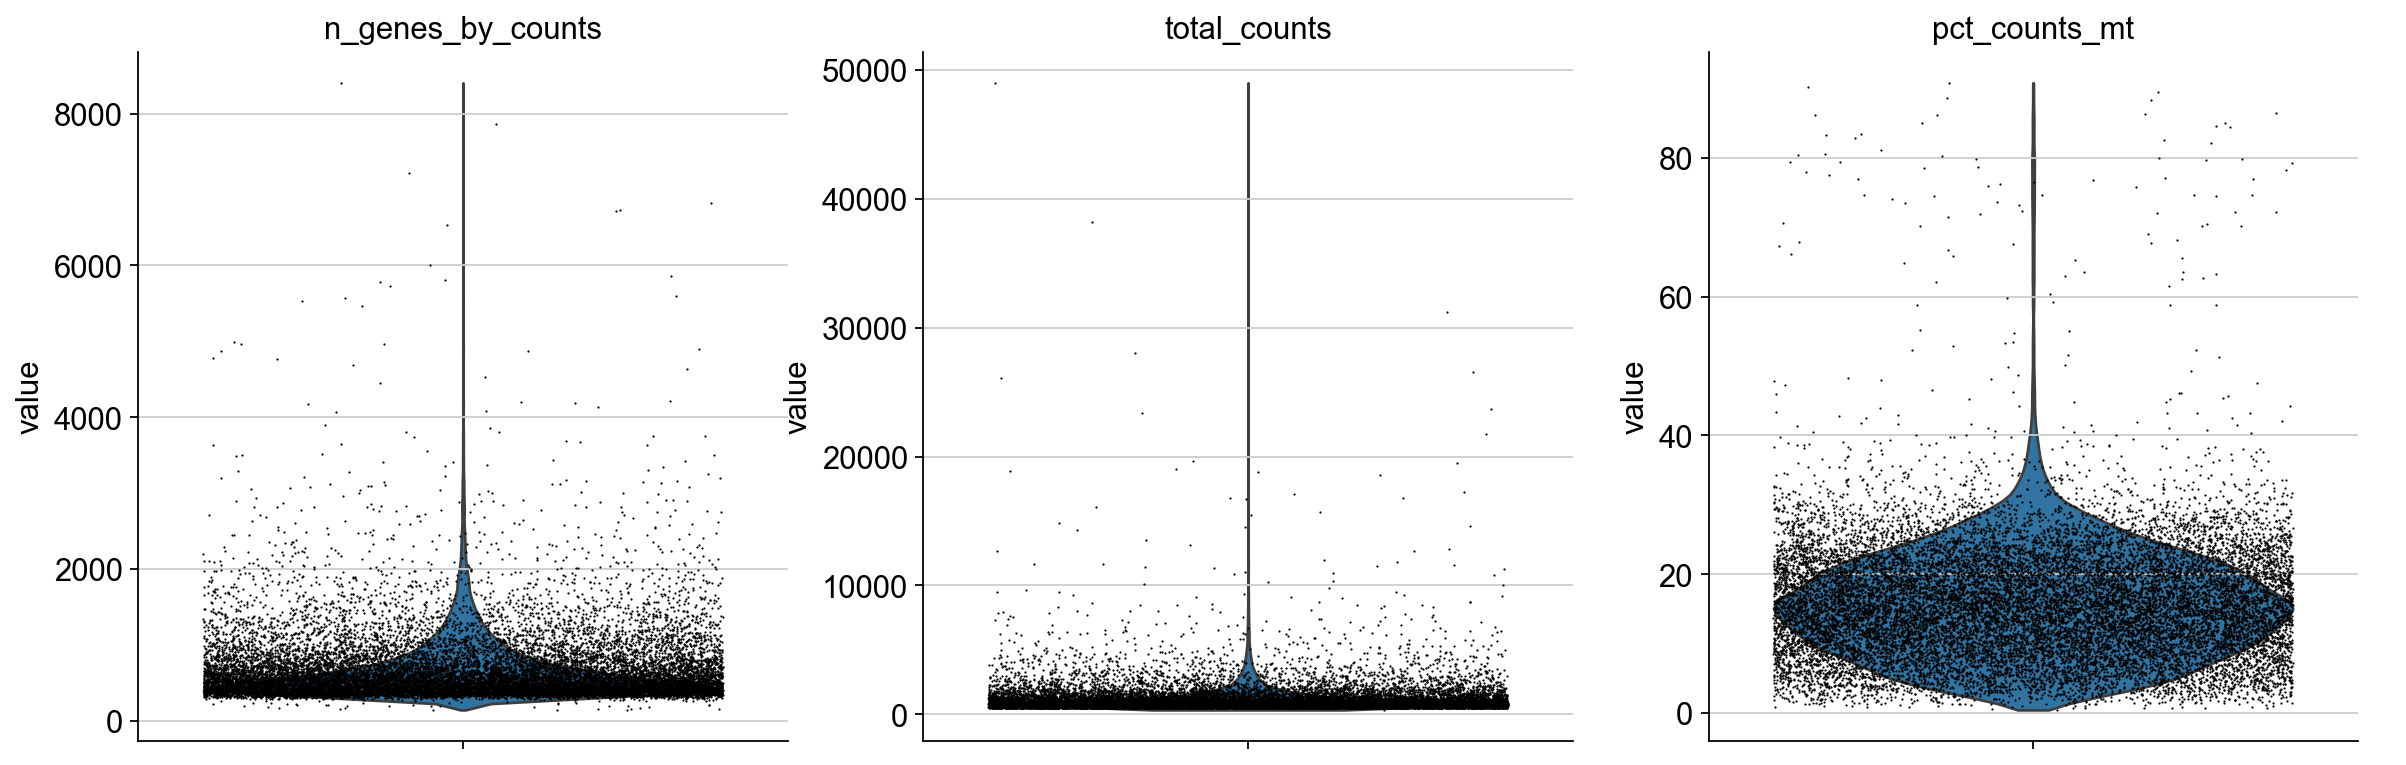

In [14]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    )

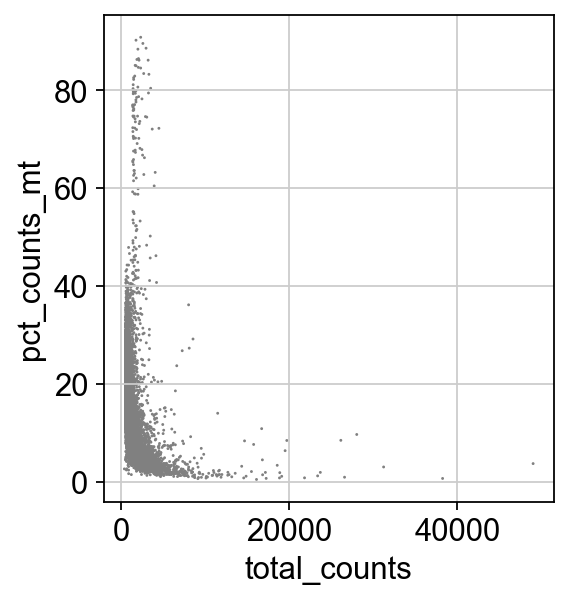

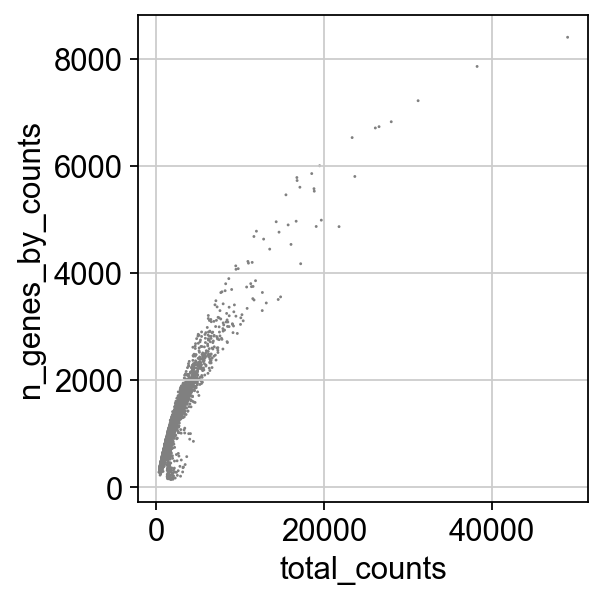

In [15]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [16]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()

In [17]:
adata

AnnData object with n_obs × n_vars = 13175 × 23938
    obs: 'Patient', 'Type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [19]:
sc.pp.log1p(adata)

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


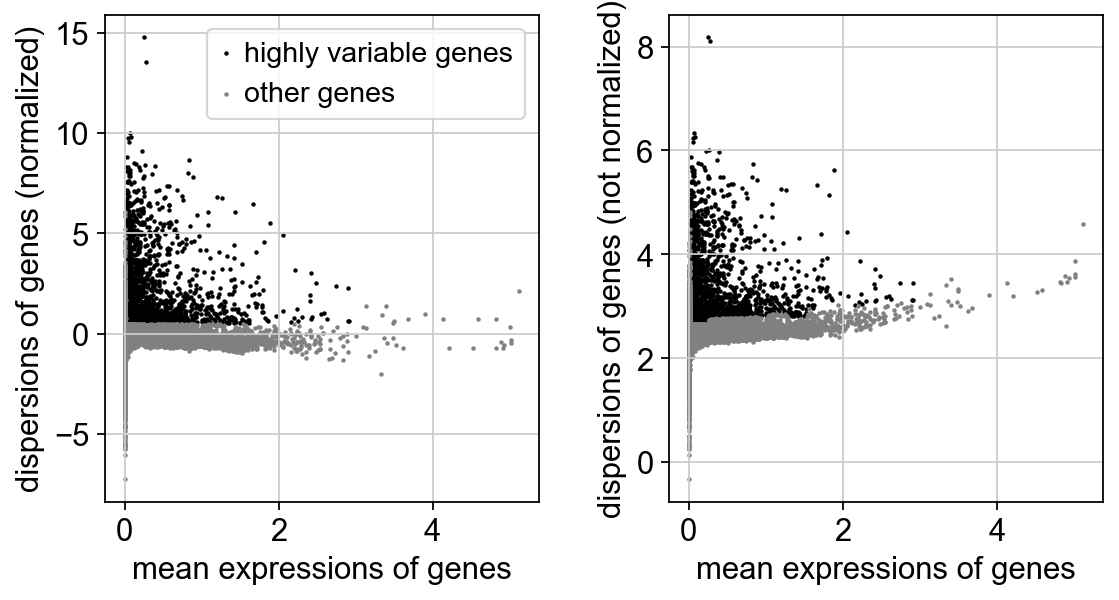

In [21]:
sc.pl.highly_variable_genes(adata)

In [22]:
#adata.raw = adata

In [23]:
adata = adata[:, adata.var.highly_variable]

In [24]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)


In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


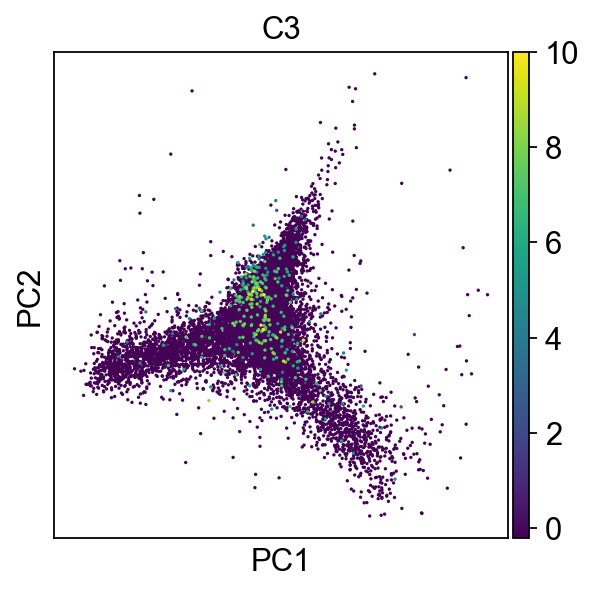

In [27]:
sc.pl.pca(adata, color="C3")

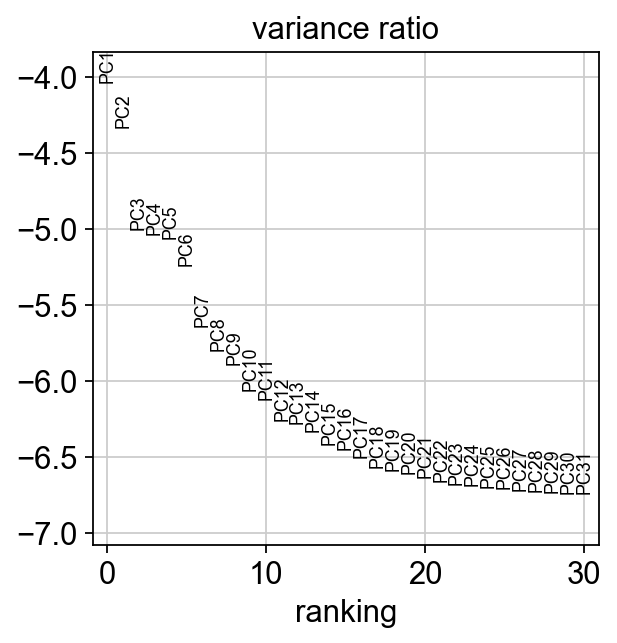

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
adata.write(results_file)

In [32]:
adata

AnnData object with n_obs × n_vars = 13175 × 1962
    obs: 'Patient', 'Type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


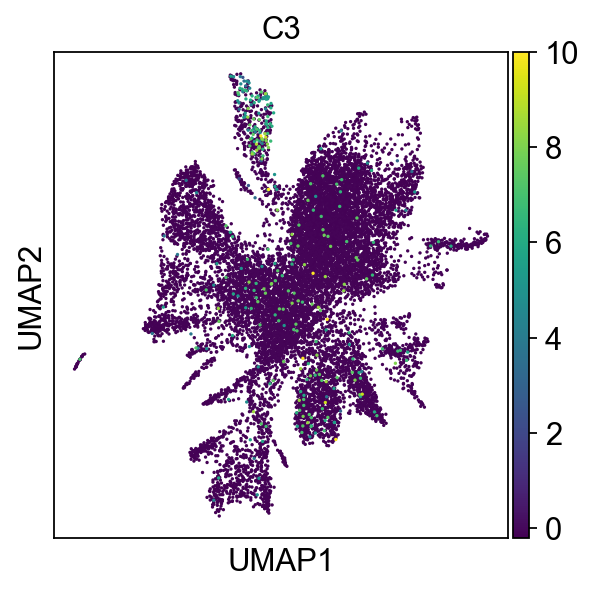

In [35]:
sc.pl.umap(adata, color=["C3"], use_raw=False)

In [36]:
sc.tl.leiden(
    adata,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [37]:
adata.var_names

Index(['CFAP74', 'GABRD', 'FAM213B', 'PRDM16', 'KCNAB2', 'LINC00337', 'CA6',
       'SLC2A5', 'PIK3CD', 'CTNNBIP1',
       ...
       'HLCS', 'RIPPLY3', 'KCNJ6', 'ERG', 'PSMG1', 'DSCAM', 'BACE2', 'PDE9A',
       'AATBC', 'AP001505.1'],
      dtype='object', length=1962)

c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\supak\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


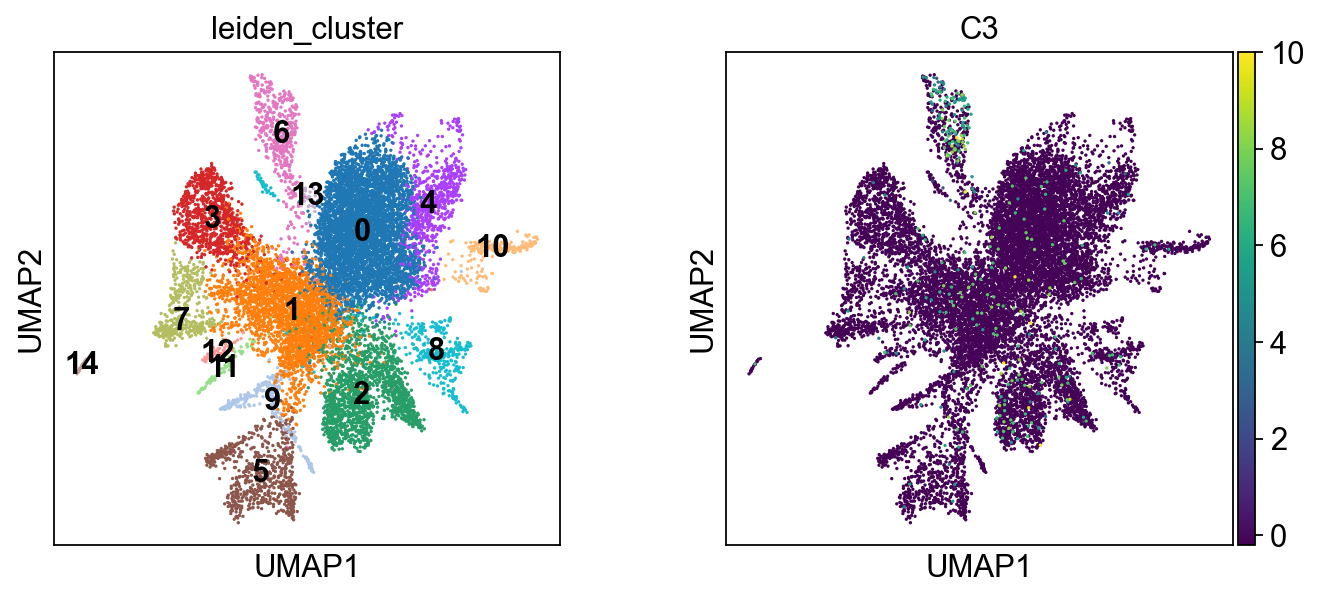

In [39]:
sc.pl.umap(adata, color=["leiden", "C3"], legend_loc="on data", title="leiden_cluster")